In [1]:
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('aiddata-countries-only.csv')
df.head()

,Unnamed: 0,aiddata_id,aiddata_2_id,year,donor,recipient,commitment_amount_usd_constant,coalesced_purpose_code,coalesced_purpose_name
0,1,2414478.0,NaN,1977,Saudi Arabia,India,348718518.0,23030,Power generation/renewable sources
1,2,2414509.0,NaN,1977,Saudi Arabia,Brazil,191647004.0,23040,Electrical transmission/ distribution
2,3,2414635.0,NaN,1983,Saudi Arabia,India,79371799.0,21030,Rail transport
3,4,2414665.0,NaN,1984,Saudi Arabia,Taiwan,212202942.0,21030,Rail transport
4,5,2414667.0,NaN,1984,Saudi Arabia,Korea,134511154.0,21040,Water transport


In [3]:
# I have decided to drop sectors (for now...) because the categoy labels are too low-level and there are >80000 unspecified sectors
df['coalesced_purpose_name'].value_counts()

Sectors not specified                                                                          8076
Social/ welfare services                                                                       6228
Strengthening civil society                                                                    5600
Higher education                                                                               4593
Multisector aid                                                                                3026
Material relief assistance and services                                                        2243
Education facilities and training                                                              2144
Administrative costs                                                                           1866
Agricultural development                                                                       1654
Vocational training                                                                            1613


In [4]:
# Sanity check: Each row represents a unique year, donor, recipient and sector
df[(df['donor'] == 'United States') &(df['year'] == 1977)]

,Unnamed: 0,aiddata_id,aiddata_2_id,year,donor,recipient,commitment_amount_usd_constant,coalesced_purpose_code,coalesced_purpose_name
62322,62323,84788704.0,6613119.0,1977,United States,Korea,124945894.0,52010,Food security programmes/food aid
62732,62733,84985067.0,6520467.0,1977,United States,Thailand,720668.0,60010,Action relating to debt
63336,63337,85304884.0,6529786.0,1977,United States,Korea,6125682.0,60010,Action relating to debt
63958,63959,85627686.0,6519458.0,1977,United States,Thailand,9008356.0,31181,Agricultural education/training
64894,64895,86129314.0,6539424.0,1977,United States,Thailand,13512534.0,43040,Rural development
64922,64923,86142340.0,6529342.0,1977,United States,Korea,5855431.0,60010,Action relating to debt
65288,65289,86338964.0,6529675.0,1977,United States,Chile,180167.0,60010,Action relating to debt
65776,65777,86632775.0,6520060.0,1977,United States,Korea,1441337.0,60010,Action relating to debt
66560,66561,87035484.0,6520430.0,1977,United States,Korea,9879163.0,60010,Action relating to debt
67222,67223,87377778.0,6520134.0,1977,United States,Korea,360334.0,60010,Action relating to debt


In [5]:
#Group by year, donor, recipient and sum up the commitment amount
df = df[['year', 'donor', 'recipient', 'commitment_amount_usd_constant']]
df_new = df.groupby(['year', 'donor', 'recipient']).sum().reset_index()
df_new = df_new.reset_index().rename(columns={'index':'id', 'commitment_amount_usd_constant': 'amount'})

#Convert year from int to string
df_new['year'] = df_new['year'].astype(str)
df_new.head()

,id,year,donor,recipient,amount
0,0,1973,Australia,India,36565064.0
1,1,1973,Australia,Korea,1162012.0
2,2,1973,Australia,Thailand,8558787.0
3,3,1973,Belgium,Colombia,6541889.0
4,4,1973,Belgium,India,32709447.0


In [6]:
df_new.year.unique()

array(['1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013'], dtype=object)

In [7]:
def flatten_multi_index(df):
    mi = df.columns
    suffixes, prefixes = mi.levels
    col_names = [prefixes[i_p] + '_' + suffixes[i_s] for (i_s, i_p) in zip(*mi.labels)]
    df.columns = col_names
    return df

In [8]:
df_new.recipient.unique()

array(['India', 'Korea', 'Thailand', 'Colombia', 'Brazil', 'Chile',
       'Cyprus', 'Kuwait', 'Saudi Arabia', 'United Arab Emirates',
       'Taiwan', 'Australia', 'Austria', 'Belgium', 'Canada', 'Denmark',
       'France', 'Greece', 'Iceland', 'Ireland', 'Italy', 'Japan',
       'New Zealand', 'Norway', 'Poland', 'Portugal', 'Romania', 'Spain',
       'Sweden', 'United Kingdom', 'Liechtenstein', 'Finland', 'Hungary',
       'South Africa', 'Qatar', 'Czech Republic', 'Latvia', 'Estonia',
       'Lithuania', 'Slovenia', 'Slovak Republic', 'Luxembourg',
       'Switzerland', 'United States', 'Germany'], dtype=object)

## Data Processing - Global Distribution of Donors/Recipients

In [9]:
class DataProcessing_GlobalDistribution():
    
    def __init__(self):
        
        """
        Entities could be: donor/recipient
        This class contains functions to calculate the total sum of commitment amount as either a donor/recipient on a yearly basis
        """

    def final(self, df):

        # [DESTINATION]
        destination_count = self.global_stats(df, 'recipient')

        # [SOURCE]
        source_count = self.global_stats(df, 'donor')

        # Global count
        all_country = pd.concat([source_count, destination_count])
        all_country_PT = self.country_count_PT(all_country)
      
        for c in ['donor', 'recipient']:
            for country in list(set(list(df.donor.unique()) + list(df.recipient.unique()))):
                for i in range(1973, 2014):
                    tmp = all_country[(all_country['year'] == i) & (all_country['country'] == country) & (all_country['category'] == c)]
                    if(len(tmp)==0):
                        new = pd.DataFrame({'year': i, 'country': country, 'category': c, 'sum':0}, index=[0])
                        all_country = pd.concat([all_country, new])
    
        all_country_all = pd.DataFrame(all_country.groupby(['category','year'])['sum'].sum()).reset_index()
        all_country_all['country'] = 'All'
        all_country = pd.concat([all_country, all_country_all])
        all_country = all_country.sort_values(['category', 'year'], ascending=True).reset_index(drop=True)
        
        # Sum
        net_all = pd.DataFrame()
        for country in list(set(list(df_new.donor.unique()) + list(df_new.recipient.unique()))):
            tmp = all_country_PT[all_country_PT['country'] == country]
            donor = tmp[tmp['category'] == 'donor'].drop(['country', 'category'], axis=1).reset_index(drop=True)
            recipient = tmp[tmp['category'] == 'recipient'].drop(['country', 'category'], axis=1).reset_index(drop=True)
            if((len(donor)>0) & (len(recipient)>0)):
                net = donor.add(recipient)
            elif (len(donor)==0):
                net = recipient 
            elif (len(recipient)==0):
                net = donor 
            net['country'] = country
            net_all = pd.concat([net_all, net])

        net_all['category'] = 'net'
        net_all = net_all.fillna(0).reset_index(drop=True)
        all_country_PT = pd.concat([all_country_PT, net_all])

        # Global density (in %)
        all_country_pctPT = self.country_pct_PT(all_country)
    
        all_country = all_country.reset_index(drop=True)
        all_country['year'] = all_country['year'].astype(dtype = int, errors = 'ignore')
        for i,row in all_country.iterrows():
            if (all_country.loc[i, 'year'] == 'All'):
                all_country.loc[i, 'group'] = 'All'
            elif (all_country.loc[i, 'year'] >= 1973) & (all_country.loc[i, 'year'] <= 1976):
                all_country.loc[i, 'group'] = '1973-1976'
            elif (all_country.loc[i, 'year'] >= 1977) & (all_country.loc[i, 'year'] <= 1980):
                all_country.loc[i, 'group'] = '1977-1980'
            elif (all_country.loc[i, 'year'] >= 1981) & (all_country.loc[i, 'year'] <= 1984):
                all_country.loc[i, 'group'] = '1981-1984'
            elif (all_country.loc[i, 'year'] >= 1985) & (all_country.loc[i, 'year'] <= 1988):
                all_country.loc[i, 'group'] = '1985-1988'
            elif (all_country.loc[i, 'year'] >= 1989) & (all_country.loc[i, 'year'] <= 1992):
                all_country.loc[i, 'group'] = '1989-1992'
            elif (all_country.loc[i, 'year'] >= 1993) & (all_country.loc[i, 'year'] <= 1996):
                all_country.loc[i, 'group'] = '1993-1996'
            elif (all_country.loc[i, 'year'] >= 1997) & (all_country.loc[i, 'year'] <= 2000):
                all_country.loc[i, 'group'] = '1997-2000'
            elif (all_country.loc[i, 'year'] >= 2001) & (all_country.loc[i, 'year'] <= 2004):
                all_country.loc[i, 'group'] = '2001-2004'
            elif (all_country.loc[i, 'year'] >= 2005) & (all_country.loc[i, 'year'] <= 2008):
                all_country.loc[i, 'group'] = '2005-2008'
            elif (all_country.loc[i, 'year'] >= 2009) & (all_country.loc[i, 'year'] <= 2013):
                all_country.loc[i, 'group'] = '2009-2013'
                
        return all_country, all_country_PT.reset_index(drop=True), all_country_pctPT.reset_index(drop=True)
    
    def global_stats(self, df, category):

        country_stats = pd.DataFrame()

        tmp_g1 = pd.DataFrame(df.groupby([category])['amount'].sum()).reset_index().rename(columns={'amount': 'sum'}) 
        tmp_g1['year'] = "All"
        tmp_pcts = pd.DataFrame(df.groupby([category])['amount'].sum()).apply(lambda x: 100 * x / float(x.sum())).reset_index().rename(columns={'amount': 'pct'})
        tmp_g1['year'] = "All"
        new = pd.merge(tmp_g1, tmp_pcts, on=category, how='left')
        country_stats = pd.concat([country_stats, new])
        
        # segment by year
        for i in df['year'].unique():
            tmp = df[df['year'] == i]
            if(len(tmp) > 0):
                tmp_g1 = pd.DataFrame(tmp.groupby([category])['amount'].sum()).reset_index().rename(columns={'amount': 'sum'})     
                tmp_g1['year'] = int(i)
                tmp_pcts =  pd.DataFrame(tmp.groupby([category])['amount'].sum()).apply(lambda x: 100 * x / float(x.sum())).reset_index().rename(columns={'amount': 'pct'})
                tmp_pcts['year'] = int(i)
                tmp_pcts = pd.merge(tmp_g1, tmp_pcts, on=[category, 'year'], how='left')
                country_stats = pd.concat([country_stats, tmp_pcts])
                
        country_stats['category'] = category
        country_stats = country_stats.rename(columns={category: 'country'})
        return country_stats

    def country_count_PT(self, df):
        
        all_stats_PT = pd.pivot_table(df, values='sum', index=['country', 'category'], columns=['year']) 
        all_stats_PT.fillna(0, inplace=True)
        return all_stats_PT.reset_index()

    def country_pct_PT(self, df):

        all_stats_PT = pd.pivot_table(df, values='pct', index=['country', 'category'], columns=['year']) 
        all_stats_PT.fillna(0, inplace=True)
        return all_stats_PT.reset_index()
    
    
    def rollup_time_count(self, df, groupby_list):

        df_time = pd.DataFrame(df.groupby(groupby_list)['student_since'].count()).reset_index()
        df_time['rollup'] = df_time.loc[0, 'student_since']
        for i,row in df_time.iterrows():
            try:
                df_time.loc[i+1, 'rollup'] = df_time.loc[i, 'rollup'] + df_time.loc[i+1, 'student_since'] 
            except:
                pass

        df_time['time'] = df_time.apply(lambda row: str(row['year']) + '-' + str(row['semester']), axis=1)
        return df_time
    

In [10]:
gd = DataProcessing_GlobalDistribution()

In [11]:
all_country, all_country_PT, all_country_pctPT = gd.final(df_new)

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

In [12]:
all_country_pctPT[["All"]].values.sum()

200.00000000000003

In [13]:
all_country.to_csv('all_country.csv', index=False)
all_country_PT.to_csv('all_country_PT.csv', index=False)
all_country_pctPT.to_csv('all_country_pctPT.csv', index=False)

## Data Processing - Country-To-Country Connections

In [14]:
class DataProcessing_CountryToCountry():
    
    def __init__(self):
        
        """
        A country could be:
        1) Donor
        2) Recipient
        3) Both risk source and destination
        This is a class containing functions to find the density of connections a country has to other countries based on relationship on a yearly basis 
        """

    def final(self, df):
     
        """
        Output: Transformed data ready for input into chart
        
        Parameters:
        df: Cleaned dataframe of each relationship between country
        """
      
        wn_country_donor = self.country_to_country(df, ['donor','recipient'])                                                                      
        wn_country_recipient = self.country_to_country(df, ['recipient', 'donor'])   
        wn_country_net = self.net(df)
        wn_country_PT = self.country_flow_PT(wn_country_donor, wn_country_recipient, wn_country_net)
        return wn_country_PT
    
    def country_to_country(self, df, X):

        """
        Output: Count and percentage of connections to each country, segmented by year
        """
        
        country_stats = pd.DataFrame()

        tmp = pd.DataFrame(df.groupby(X)['amount'].sum()).reset_index()
        tmp['year'] = 'All'
        country_stats = pd.concat([country_stats, tmp])
        
        # segment by year
        for i in df['year'].unique():
            tmp = df[df['year'] == i]
            if(len(tmp) > 0):
                tmp = pd.DataFrame(tmp.groupby(X)['amount'].sum()).reset_index()    
                tmp['year'] = str(int(i))
                country_stats = pd.concat([country_stats, tmp])

        country_stats = country_stats[['year', 'donor', 'recipient', 'amount']]
        
        return country_stats

    def net(self, df):
        
        rsAll1= pd.DataFrame(df.groupby(['donor','recipient'])['amount'].sum()).reset_index()
        rsAll1 = rsAll1.rename(columns={'recipient': 'country 2', 'donor': 'country 1', 'amount': 'outflow'})
        rsAll1['year'] = 'All'
        rsAll2 = pd.DataFrame(df.groupby(['recipient', 'donor'])['amount'].sum()).reset_index()
        rsAll2 = rsAll2.rename(columns={'donor': 'country 2', 'recipient': 'country 1', 'amount': 'inflow'})
        rsAll2['year'] = 'All'
        
        rs1 = pd.DataFrame()
        rs2 = pd.DataFrame()
        for i in list(set(list(df.donor.unique()) + list(df.recipient.unique()))):
            tmp1 = df[(df['donor'] == i)]
            rs1 = pd.concat([rs1, tmp1])
            tmp2 = df[(df['recipient'] == i)]
            rs2 = pd.concat([rs2, tmp2])

        rs1 = rs1.rename(columns={'recipient': 'country 2', 'donor': 'country 1', 'amount': 'outflow'})
        rs2 = rs2.rename(columns={'donor': 'country 2', 'recipient': 'country 1', 'amount': 'inflow'})
    
        net = pd.merge(rs1, rs2, on=['country 1', 'country 2', 'year'], how='left')
        net = pd.concat([net, rsAll1, rsAll2])
        net['inflow'] = net['inflow'].fillna(0)
        net['outflow'] = net['outflow'].fillna(0)
        net['net'] = net['outflow'] - net['inflow']
        net['value'] = net['outflow'] + net['inflow']
        net = net.rename(columns={'country 1': 'country'})
        
        return net[['country', 'country 2', 'inflow', 'outflow', 'year', 'net', 'value']]
    
    def country_flow_PT(self, df1, df2, df3):

        df1_PT = pd.pivot_table(df1, values='amount', index=['donor'], columns=['year', 'recipient']) 
        df1_PT = flatten_multi_index(df1_PT).reset_index().rename(columns={'donor': 'country'})
        df1_PT['category'] = 'recipient'

        df2_PT = pd.pivot_table(df2, values='amount', index=['recipient'], columns=['year', 'donor']) 
        df2_PT = flatten_multi_index(df2_PT).reset_index().rename(columns={'recipient': 'country'})
        df2_PT['category'] = 'donor'

        df3_PT = pd.pivot_table(df3, values='net', index=['country'], columns=['year', 'country 2']) 
        df3_PT = flatten_multi_index(df3_PT).reset_index()
        df3_PT['category'] = 'net'
        
        df = pd.concat([df1_PT, df2_PT, df3_PT])
        df_PT = pd.pivot_table(df, index=['country'], columns=['category']) 
        df_PT = flatten_multi_index(df_PT).reset_index()
        df_PT = df_PT.fillna(0)

        return df_PT

In [15]:
ctc = DataProcessing_CountryToCountry()

In [16]:
wn_country_PT = ctc.final(df_new)

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  after removing the cwd from sys.path.
/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:96: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [17]:
wn_country_PT.head()

,country,donor_Australia_1973,donor_Australia_1974,donor_Australia_1975,donor_Australia_1976,donor_Australia_1977,donor_Australia_1978,donor_Australia_1979,donor_Australia_1980,net_Australia_1980,...,net_United States_2008,recipient_United States_2008,donor_United States_2009,donor_United States_2010,donor_United States_2011,donor_United States_2012,donor_United States_2013,donor_United States_All,net_United States_All,recipient_United States_All
0,Australia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.572618e+09,-2.572618e+09,0.0
1,Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.699085e+08,-7.699085e+08,0.0
2,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.843462e+08,-1.843462e+08,0.0
3,Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,55528517.0,31086679.0,33062881.0,21104514.0,49846811.0,1.354834e+10,-1.354834e+10,0.0
4,Canada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.068597e+09,-4.068597e+09,0.0


In [18]:
max(wn_country_PT.drop(['country'], axis=1).max(axis = 0).values)

48830067295.0

In [19]:
wn_country_PT.to_csv('wn_country_PT.csv', index=False) 

In [20]:
class DataProcessing_CountrySnapshot():
    
    def __init__(self):
        
        """
        Country-level metrics
        """

    def countries_ranking(self, df_filt):
     
        """
        To rank countries connected to each country either as a donor/recipient based on commitment amount
        
        Parameters:
        df: Cleaned dataframe of each relationship between country
        """
    
        #[SOURCE]
        top_exposing = df_filt.groupby(['recipient', 'donor'])['amount'].sum().reset_index()
        top_exposing = top_exposing.sort_values('amount',ascending=False)
        top_exposing['category'] = 'recipient'
        
        #[DESTINATION]
        top_exposedby = df_filt.groupby(['donor', 'recipient'])['amount'].sum().reset_index()
        top_exposedby = top_exposedby.sort_values('amount',ascending=False)
        top_exposedby['category'] = 'donor'

        countries_ranking = pd.concat([top_exposing, top_exposedby])
        countries_ranking = countries_ranking.rename(columns={'amount': 'sum'})

        return countries_ranking
   

In [21]:
country = DataProcessing_CountrySnapshot()
countries_ranking = country.countries_ranking(df_new)

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [22]:
countries_ranking.to_csv('countries_ranking.csv', index=False)

In [23]:
countries_ranking

,sum,category,donor,recipient
197,4.883007e+10,recipient,Japan,India
466,3.543769e+10,recipient,Japan,Thailand
215,1.992198e+10,recipient,United Kingdom,India
192,1.801798e+10,recipient,Germany,India
301,1.723075e+10,recipient,Germany,Poland
94,1.710424e+10,recipient,United States,Colombia
216,1.652983e+10,recipient,United States,India
32,1.354834e+10,recipient,United States,Brazil
231,1.302945e+10,recipient,Japan,Korea
238,1.115436e+10,recipient,United States,Korea


## Data Processing - GDP

In [81]:
gdp = pd.read_csv('./gdp_per_capita_currentUS.csv')
gdp = gdp.drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1).rename(columns={'Country Name' : 'country'}).sort_values('country', ascending=True).reset_index(drop=True)

taiwan = [{'1960': 163, '1961': 161, '1962': 172, '1963': 189, '1964': 214, '1965': 229, '1966': 249, '1967': 281, \
          '1968': 319, '1969': 357, '1970': 397, '1971': 451, '1972': 530, '1973': 706, '1974': 934, '1975': 985, \
          '1976': 1158, '1977': 1330, '1978': 1606, '1979': 1950, '1980': 2389, '1981': 2721, '1982': 2700, \
          '1983': 2904, '1984': 3225, '1985': 3315, '1986': 4038, '1987': 5350, '1988': 6369, '1989': 7614, \
          '1990': 8216, '1991': 9136, '1992': 10778, '1993': 11251, '1994': 12160, '1995': 13129, '1996':13650, \
          '1997': 14040, '1998': 12840, '1999': 13189, '2000':14941, '2001': 13448, '2002': 13750, '2003': 14120, \
          '2004': 15388, '2005': 16532, '2006': 17026, '2007':17814, '2008': 18131, '2009': 16988, '2010': 19278, \
          '2011': 20939, '2012': 21308, '2013': 21916, '2014': 22668, '2015': 22400, '2016': 22592, '2017': 24408, \
          '2018': 25026}] 
taiwan = pd.DataFrame(taiwan, index =['Taiwan']) 
taiwan['country'] = 'Taiwan'
gdp = pd.concat([gdp, taiwan])

# country label fixes...Taiwan and Korea have different labelling in World Bank data
gdp = gdp.replace('Korea, Rep.', 'Korea')

gdp_m = pd.melt(gdp, id_vars=['country']).rename(columns={'variable': 'year'})
gdp_m['year'] = gdp_m['year'].astype(int)

def group_years(all_country):

    for i,row in all_country.iterrows():
        if (all_country.loc[i, 'year'] == 'All'):
            all_country.loc[i, 'group'] = 'All'
        elif (all_country.loc[i, 'year'] >= 1973) & (all_country.loc[i, 'year'] <= 1976):
            all_country.loc[i, 'group'] = '1973-1976'
        elif (all_country.loc[i, 'year'] >= 1977) & (all_country.loc[i, 'year'] <= 1980):
            all_country.loc[i, 'group'] = '1977-1980'
        elif (all_country.loc[i, 'year'] >= 1981) & (all_country.loc[i, 'year'] <= 1984):
            all_country.loc[i, 'group'] = '1981-1984'
        elif (all_country.loc[i, 'year'] >= 1985) & (all_country.loc[i, 'year'] <= 1988):
            all_country.loc[i, 'group'] = '1985-1988'
        elif (all_country.loc[i, 'year'] >= 1989) & (all_country.loc[i, 'year'] <= 1992):
            all_country.loc[i, 'group'] = '1989-1992'
        elif (all_country.loc[i, 'year'] >= 1993) & (all_country.loc[i, 'year'] <= 1996):
            all_country.loc[i, 'group'] = '1993-1996'
        elif (all_country.loc[i, 'year'] >= 1997) & (all_country.loc[i, 'year'] <= 2000):
            all_country.loc[i, 'group'] = '1997-2000'
        elif (all_country.loc[i, 'year'] >= 2001) & (all_country.loc[i, 'year'] <= 2004):
            all_country.loc[i, 'group'] = '2001-2004'
        elif (all_country.loc[i, 'year'] >= 2005) & (all_country.loc[i, 'year'] <= 2008):
            all_country.loc[i, 'group'] = '2005-2008'
        elif (all_country.loc[i, 'year'] >= 2009) & (all_country.loc[i, 'year'] <= 2013):
            all_country.loc[i, 'group'] = '2009-2013'

    return all_country
                
gdp_m = group_years(gdp_m)

# Aggregate aid and GDP over 5 years
gdp_m_agg = gdp_m.groupby(['country', 'group']).mean().reset_index().drop(['year'], axis=1)

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [72]:
all_country_gdp = pd.merge(all_country, gdp_m, on=['country', 'year', 'group'], how='left')
all_country_gdp[all_country_gdp['country'].isnull()].country.unique()
all_country_gdp = all_country_gdp[(all_country_gdp['year'] != 'All') & (all_country_gdp['category'] == 'donor')]

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [ ]:
all_country_PT1 = all_country_PT.copy(deep=True)

In [ ]:
for i,row in all_country_PT.iterrows():
    for year in range(1973, 2013): 
        tmp = gdp[gdp['country'] == row['country']][str(year)].values
        if len(tmp>0):
            all_country_PT.loc[i, "scaled_" + str(year)] = all_country_PT.loc[i, year]/tmp[0]

## CONNECTED SCATTERPLOT x: timeline, y: % of donor/recipients, radius of markers: size of GDP (aggregated over 5 years)

In [28]:
# Calculate donor-to-recipient ratio

perc_all = pd.DataFrame()
for country in list(set(list(df_new.donor.unique()) + list(df_new.recipient.unique()))):
    donor = all_country_PT1[(all_country_PT1['country'] == country) & (all_country_PT1['category'] == 'donor')].reset_index(drop=True)
    net = all_country_PT1[(all_country_PT1['country'] == country) & (all_country_PT1['category'] == 'net')].reset_index(drop=True)
    perc = donor.drop(['country', 'category'], axis=1).div(net.drop(['country', 'category'], axis=1))
    perc['country'] = country
    perc_all = pd.concat([perc_all, perc])

perc_all['category'] = 'donor_ratio'
perc_all = perc_all.fillna(0).reset_index(drop=True)
all_country_PT1 = pd.concat([all_country_PT1, perc_all])  

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [29]:
perc_all = pd.DataFrame()
for country in list(set(list(df_new.donor.unique()) + list(df_new.recipient.unique()))):
    recipient = all_country_PT1[(all_country_PT1['country'] == country) & (all_country_PT1['category'] == 'recipient')].reset_index(drop=True)
    net = all_country_PT1[(all_country_PT1['country'] == country) & (all_country_PT1['category'] == 'net')].reset_index(drop=True)
    perc = recipient.drop(['country', 'category'], axis=1).div(net.drop(['country', 'category'], axis=1))
    perc['country'] = country
    perc_all = pd.concat([perc_all, perc])
                                                                                                                                                                                                                
perc_all['category'] = 'recipient_ratio'
perc_all = perc_all.fillna(0).reset_index(drop=True)
all_country_PT1 = pd.concat([all_country_PT1, perc_all])                                                                                                                                                                         

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [30]:
#d_r_ratio = all_country_PT1[(all_country_PT1['category'] == 'donor_ratio') | (all_country_PT1['category'] == 'recipient_ratio')]

d_ratio = all_country_PT1[(all_country_PT1['category'] == 'donor_ratio')]
r_ratio = all_country_PT1[(all_country_PT1['category'] == 'recipient_ratio')]

In [31]:
for i,row in d_ratio.iterrows():
    for year in range(1973, 2014):
        if(d_ratio.loc[i, year])==0:
            d_ratio.loc[i, year] = -r_ratio[r_ratio['country'] == d_ratio.loc[i].country][year].values[0]

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
d_ratio.replace(-0, 0, inplace=True)

/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:4032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [33]:
all_country_PT1_new = pd.melt(d_ratio, id_vars=['country', 'category']).rename(columns={'variable': 'year'})

all_country_PT1_donor = all_country_PT1_new[(all_country_PT1_new['category'] == 'donor_ratio') & \
                                            (all_country_PT1_new['year'] != 'All')]
all_country_PT1_donor = group_years(all_country_PT1_donor)

#all_country_PT1_recipient = all_country_PT1_new[(all_country_PT1_new['category'] == 'recipient_ratio') & \
                                            #(all_country_PT1_new['year'] != 'All')]
#all_country_PT1_recipient = group_years(all_country_PT1_recipient)


/Users/dianaow/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [34]:
# Aggregate donor-to-recipient ratio over 5 years
all_country_PT1_donor_agg = all_country_PT1_donor.groupby(['country', 'category', 'group']).mean().reset_index()

#all_country_PT1_recipient_agg = all_country_PT1_recipient.groupby(['country', 'category', 'group']).mean().reset_index()

#all_country_PT1_recipient_agg = pd.merge(all_country_PT1_recipient_agg, gdp_m_agg.rename(columns={'value': 'gdp'}),\
                                   #on=['country', 'group'], how='left')

In [35]:
all_country_PT1_donor_agg

,country,category,group,value
0,Australia,donor_ratio,1973-1976,1.000000
1,Australia,donor_ratio,1977-1980,0.824833
2,Australia,donor_ratio,1981-1984,0.706245
3,Australia,donor_ratio,1985-1988,1.000000
4,Australia,donor_ratio,1989-1992,0.807166
5,Australia,donor_ratio,1993-1996,0.421438
6,Australia,donor_ratio,1997-2000,0.827691
7,Australia,donor_ratio,2001-2004,0.765239
8,Australia,donor_ratio,2005-2008,1.000000
9,Australia,donor_ratio,2009-2013,1.000000


In [36]:
donor_ratio = pd.pivot_table(all_country_PT1_donor_agg, index='group', columns='country', values='value').reset_index()
#recipient_ratio = pd.pivot_table(all_country_PT1_recipient_agg, index='group', columns='country', values='value').reset_index()

#### Sanity check

In [37]:
d_ratio[d_ratio['country'] == 'Brazil']

,country,category,1973,1974,1975,1976,1977,1978,1979,1980,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,All
45,Brazil,donor_ratio,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,0.00012,0.000293,-1.0,0.000863,-1.0,-1.0,-1.0,0.000031


In [38]:
d_ratio[d_ratio['country'] == 'Brazil']

,country,category,1973,1974,1975,1976,1977,1978,1979,1980,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,All
45,Brazil,donor_ratio,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,0.00012,0.000293,-1.0,0.000863,-1.0,-1.0,-1.0,0.000031


In [39]:
r_ratio[r_ratio['country'] == 'Brazil']

,country,category,1973,1974,1975,1976,1977,1978,1979,1980,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,All
45,Brazil,recipient_ratio,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.99988,0.999707,1.0,0.999137,1.0,1.0,1.0,0.999969


In [40]:
donor_ratio.to_csv('all_country_agg.csv', index=False)

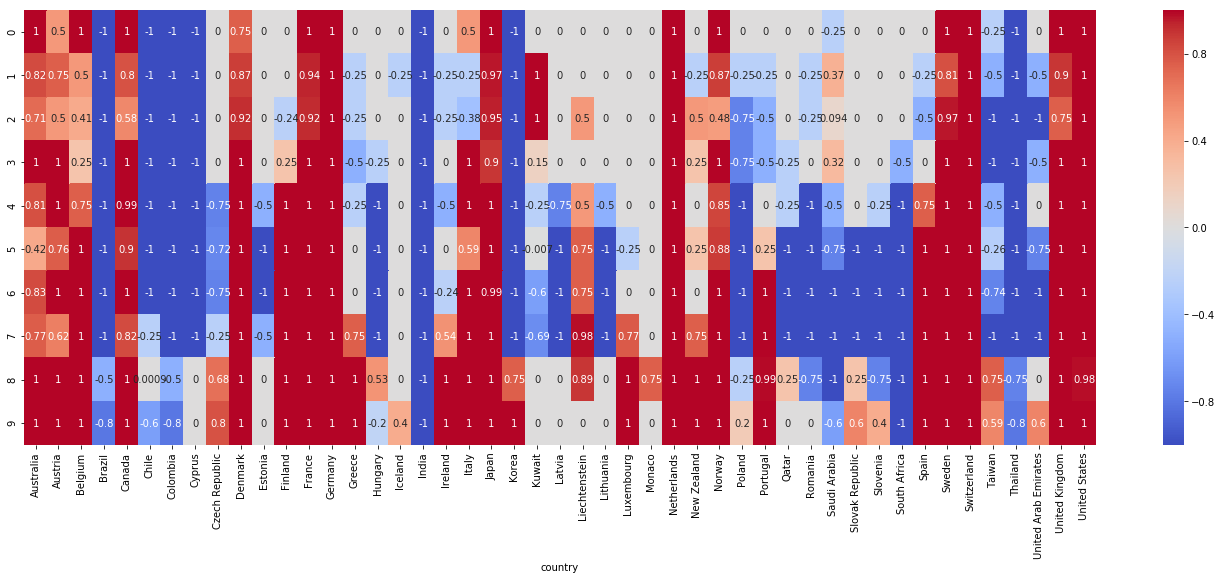

In [41]:
plt.figure(figsize=(24,8))
sns.heatmap(donor_ratio.drop('group', axis=1), cmap='coolwarm', vmin=-1, center=0, vmax=1, annot=True)

In [42]:
donor_ratio[['Korea', 'Taiwan', 'Slovak Republic', 'Poland', 'Slovenia', 'United Arab Emirates', 'Qatar', 'Kuwait']]

country,Korea,Taiwan,Slovak Republic,Poland,Slovenia,United Arab Emirates,Qatar,Kuwait
0,-1.00,-0.250000,0.00,0.00,0.00,0.00,0.00,0.000000
1,-1.00,-0.500000,0.00,-0.25,0.00,-0.50,0.00,1.000000
2,-1.00,-1.000000,0.00,-0.75,0.00,-1.00,0.00,0.999934
3,-1.00,-1.000000,0.00,-0.75,0.00,-0.50,-0.25,0.147690
4,-1.00,-0.500000,0.00,-1.00,-0.25,0.00,-0.25,-0.249776
5,-1.00,-0.263751,-1.00,-1.00,-1.00,-0.75,-1.00,-0.006958
6,-1.00,-0.738107,-1.00,-1.00,-1.00,-1.00,-1.00,-0.599604
7,-1.00,-1.000000,-1.00,-1.00,-1.00,-1.00,-1.00,-0.692067
8,0.75,0.750000,0.25,-0.25,-0.75,0.00,0.25,0.000000
9,1.00,0.591679,0.60,0.20,0.40,0.60,0.00,0.000000


In [43]:
# Insight => Donor/Recipient total sum ratio

#0:'1973-1978'
#1:'1979-1982'
#2:'1983-1986' Hungary, Poland, Romania were the first Soviet bloc countries to receive foreign aid 
#3:'1987-1990' The collapse of the Communist Regimes in the Soviet bloc countries of Czech Republic, Estonia, Latvia, Lithuania, Slovenia saw these countries receive aid for the first time
#4:'1991-1994' Soviet bloc countries continue to soley receive aid. Germany’s willingness to continue its historically large ODA was undermined by the financial, economic, and political costs of reunificationg
#5:'1995-1998' 
#6:'1999-2002'
#7:'2003-2006' Proportion of donations increase amongst some countries
#8:'2007-2010' Countries that start giving more donations than receiving nations: Korea, Taiwan, Slovakia, Poland, SLovenia, UAE
#9:'2011-2014' Increase in foreign aid to South American countries

In [44]:
# Aggregate aid and GDP of 40 years

gdp_m = pd.melt(gdp, id_vars=['country']).rename(columns={'variable': 'year'})
gdp_m['year'] = gdp_m['year'].astype(int)
gdp_m = gdp_m[(gdp_m['year'] > 1970) & (gdp_m['year'] < 2015)]
gdp_m_agg = gdp_m.groupby('country').mean().reset_index()
all_country_PT1_new_agg = all_country_PT1_new.groupby(['country']).mean().reset_index()
all_country_PT1_new_agg = pd.merge(all_country_PT1_new_agg, gdp_m_agg.rename(columns={'value': 'gdp'}), on=['country'], how='left')
all_country_PT1_new_agg 

,country,value,year,gdp
0,Australia,0.830902,1992.5,23049.086997
1,Austria,0.810786,1992.5,23884.444040
2,Belgium,0.798812,1992.5,22925.287116
3,Brazil,-0.904731,1992.5,4179.906675
4,Canada,0.906395,1992.5,23228.700257
5,Chile,-0.761748,1992.5,5035.589255
6,Colombia,-0.904757,1992.5,2559.739860
7,Cyprus,-0.761905,1992.5,14407.865370
8,Czech Republic,-0.074537,1992.5,11283.986925
9,Denmark,0.954911,1992.5,29709.128184


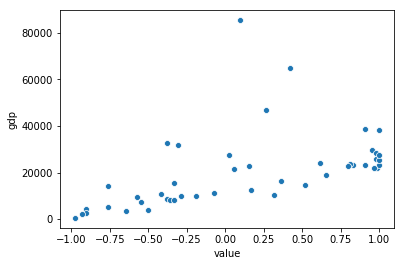

In [45]:
sns.scatterplot(x="value", y="gdp", data=all_country_PT1_new_agg )

In [46]:
pd.DataFrame(all_country.groupby(['category', 'country'])['sum'].sum()).reset_index().sort_values(['category','sum'], ascending=False)

,category,country,sum
48,recipient,All,7.336083e+11
66,recipient,India,2.679609e+11
92,recipient,Thailand,9.808263e+10
52,recipient,Brazil,7.321452e+10
55,recipient,Colombia,5.106107e+10
70,recipient,Korea,5.058865e+10
80,recipient,Poland,4.903445e+10
87,recipient,South Africa,3.731111e+10
71,recipient,Kuwait,1.554308e+10
54,recipient,Chile,1.466826e+10


## HEATMAP: growth in donations every 5 years

In [47]:
all_country_growth = all_country.groupby(['country', 'category', 'group']).mean().reset_index()
donor_growth = all_country_growth[(all_country_growth['country'] != 'All') & \
                                  (all_country_growth['category'] == 'donor') & \
                                  (all_country_growth['group'] != 'All')]
recipient_growth = all_country_growth[(all_country_growth['country'] != 'All') & \
                                      (all_country_growth['category'] == 'recipient') & \
                                      (all_country_growth['group'] != 'All')]

In [48]:
donor_growth_pct = pd.pivot_table(donor_growth, index='group', columns='country', values='sum')\
    .reset_index().set_index('group').pct_change().reset_index()
recipient_growth_pct = pd.pivot_table(recipient_growth, index='group', columns='country', values='sum')\
    .reset_index().set_index('group').pct_change().reset_index()
donor_growth_pct.replace(-1, np.nan, inplace=True)
recipient_growth_pct.replace(-1, np.nan, inplace=True)

In [49]:
all_country['year'] = all_country['year'].astype(str)

In [50]:
all_country[(all_country['country'] == 'Belgium') & (all_country['category'] == 'donor')].sort_values('year', ascending=True)

,category,country,pct,sum,year,group
1,donor,Belgium,0.815109,3.925134e+07,1973,1973-1976
50,donor,Belgium,0.640497,4.358860e+07,1974,1973-1976
97,donor,Belgium,0.914151,3.886331e+07,1975,1973-1976
146,donor,Belgium,0.977500,3.612662e+07,1976,1973-1976
194,donor,Belgium,0.727554,3.585388e+07,1977,1977-1980
242,donor,Belgium,0.670760,3.218922e+07,1978,1977-1980
290,donor,Belgium,0.929703,3.080152e+07,1979,1977-1980
368,donor,Belgium,NaN,0.000000e+00,1980,1977-1980
386,donor,Belgium,0.444974,6.191790e+07,1981,1981-1984
464,donor,Belgium,NaN,0.000000e+00,1982,1981-1984


In [51]:
all_country[(all_country['country'] == 'Portugal') & (all_country['category'] == 'donor')].sort_values('year', ascending=True)

,category,country,pct,sum,year,group
25,donor,Portugal,NaN,0.0,1973,1973-1976
74,donor,Portugal,NaN,0.0,1974,1973-1976
121,donor,Portugal,NaN,0.0,1975,1973-1976
173,donor,Portugal,NaN,0.0,1976,1973-1976
220,donor,Portugal,NaN,0.0,1977,1977-1980
268,donor,Portugal,NaN,0.0,1978,1977-1980
315,donor,Portugal,NaN,0.0,1979,1977-1980
363,donor,Portugal,NaN,0.0,1980,1977-1980
412,donor,Portugal,NaN,0.0,1981,1981-1984
458,donor,Portugal,NaN,0.0,1982,1981-1984


In [52]:
donor_growth_pct[['Saudi Arabia','United States', 'Japan', 'Germany', 'United Kingdom', 'France', 'Netherlands', 'Canada', 'Sweden', 'Norway', 'Italy', 'Greece']]

country,Saudi Arabia,United States,Japan,Germany,United Kingdom,France,Netherlands,Canada,Sweden,Norway,Italy,Greece
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,inf,0.937837,-0.003606,-0.096855,0.133043,-0.342130,-0.023036,-0.498454,0.595479,0.892788,NaN,NaN
2,-0.383239,0.837904,0.518931,0.235285,-0.123248,0.926329,-0.084866,3.106815,-0.353209,-0.323636,inf,NaN
3,-0.575348,-0.541399,0.025731,0.204715,-0.459711,-0.173800,0.399380,-0.308661,0.019516,0.371471,1.358504,NaN
4,NaN,1.450418,0.200652,3.157664,0.638298,0.305006,-0.092579,-0.485030,2.089016,-0.520426,-0.087737,NaN
5,NaN,0.209143,0.110830,-0.698003,0.085192,-0.272777,-0.073988,0.131742,-0.628984,0.963040,1.821032,NaN
6,NaN,-0.038277,1.109682,-0.569346,0.486994,0.139866,-0.583991,1.174190,-0.347122,0.027368,-0.940171,NaN
7,NaN,-0.432247,-0.671802,0.566173,0.014945,1.013708,1.573404,-0.289411,-0.280765,0.039504,0.852499,inf
8,NaN,-0.457687,0.593814,0.175205,0.122797,-0.385549,-0.555206,-0.710721,-0.278624,0.607433,-0.020157,-0.162767
9,NaN,-0.146136,-0.053023,0.452324,-0.409860,1.543272,-0.685721,-0.082213,0.257056,0.900676,-0.104358,-0.485402


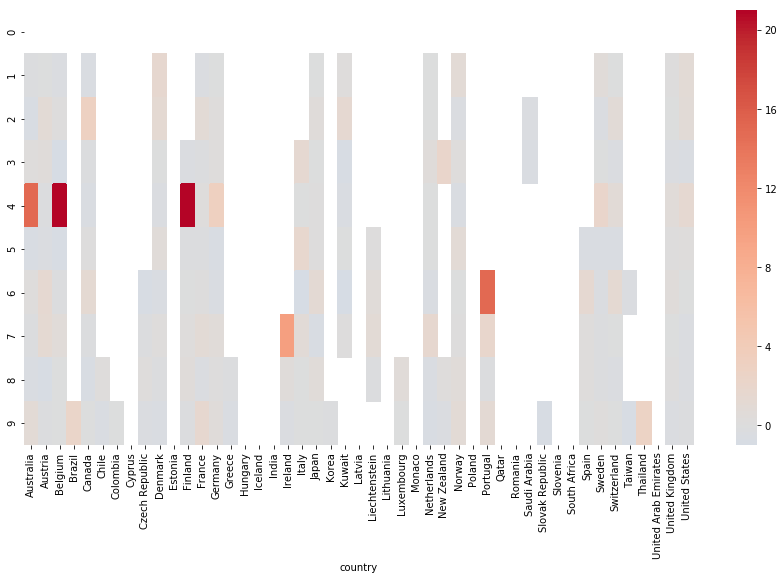

In [53]:
plt.figure(figsize=(15,8))
sns.heatmap(donor_growth_pct.drop('group', axis=1), cmap='coolwarm', vmin=-1, center=0, vmax=21)

In [54]:
# Donor growth percentage:

#0:'1973-1976'
#1:'1977-1980'
#2:'1981-1984' Hungary, Poland, Romania were the first Soviet bloc countries to receive foreign aid 
#3:'1985-1988' The collapse of the Communist Regimes in the Soviet bloc countries of Czech Republic, Estonia, Latvia, Lithuania, Slovenia saw these countries receive aid for the first time
#4:'1989-1992' Soviet bloc countries continue to soley receive aid. Germany’s willingness to continue its historically large ODA was undermined by the financial, economic, and political costs of reunificationg
#5:'1993-1996' 
#6:'1997-2000'
#7:'2001-2004' Proportion of donations increase amongst some countries
#8:'2005-2008' Countries that start giving more donations than receiving nations: Korea, Taiwan, Slovakia, Poland, SLovenia, UAE
#9:'2009-2013' Increase in foreign aid to South American countries

# 1987-1994: The collapse of the Communist Regimes in the Soviet bloc countries 
# 1999-2006: Asian Financial Crisis and slowdown of Japanese economy
# 2003-2006' Proportion of donations increase among some smaller doner countries, while donations decreased in big donor countries of 'Japan', 'United States', 'France', 'Germany' 
#'2007-2010' Interestingly, the Financial Crisis of 2007-2008 failed to deter affected nations from giving out aid. In the prelude to the financial crisis, Greece had a 4.4% increased in aid given (its highest) 
# Anomaly: Portugal doubled the aid amount given from 2001-2002
# Furthermore, in many countries the increasingly onerous foreign debt overhang appeared to confirm these doubts, suggesting that new aid, particularly loans, would only compound the problem. An ideology of international political economy that privilegesprivate capital flows and trade over aid became increasingly influential, shifting responsibility for development to the developing and transition economies themselves. In the late 1990s, dramatically increased foreign corporate investment and commercial bank lending to a few developing countries in East Asia (primarily China) and Latin America made ODA look increasingly insignificant. Certain favourable developments made aid look less essential anyway. For example, peace became the norm in Central America. It was expected that post-apartheid South Africa would provide an engine of growth for all southern Africa. A more stable Middle East involving peace between Israel and the Palestinians looked a real possibility after the 1991 Gulf War.

In [55]:
donor_growth_pct[['United States', 'France', 'Japan', 'Korea', 'Taiwan', 'United Kingdom', 'Germany']]

country,United States,France,Japan,Korea,Taiwan,United Kingdom,Germany
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.937837,-0.342130,-0.003606,NaN,NaN,0.133043,-0.096855
2,0.837904,0.926329,0.518931,NaN,NaN,-0.123248,0.235285
3,-0.541399,-0.173800,0.025731,NaN,NaN,-0.459711,0.204715
4,1.450418,0.305006,0.200652,NaN,NaN,0.638298,3.157664
5,0.209143,-0.272777,0.110830,NaN,inf,0.085192,-0.698003
6,-0.038277,0.139866,1.109682,NaN,-0.338946,0.486994,-0.569346
7,-0.432247,1.013708,-0.671802,NaN,NaN,0.014945,0.566173
8,-0.457687,-0.385549,0.593814,inf,inf,0.122797,0.175205
9,-0.146136,1.543272,-0.053023,-0.304846,-0.898179,-0.409860,0.452324


In [56]:
recipient_growth_pct[['Czech Republic', 'Estonia', 'Latvia', 'Lithuania', 'Slovenia']]

country,Czech Republic,Estonia,Latvia,Lithuania,Slovenia
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,inf,inf,inf,inf,inf
5,0.444197,5.662248,0.351056,30.605777,9.589412
6,-0.487395,-0.525630,-0.356641,-0.598511,-0.451339
7,-0.525727,0.249985,-0.167704,0.081123,-0.347446
8,-0.999780,NaN,NaN,NaN,-0.992912
9,NaN,NaN,NaN,NaN,NaN


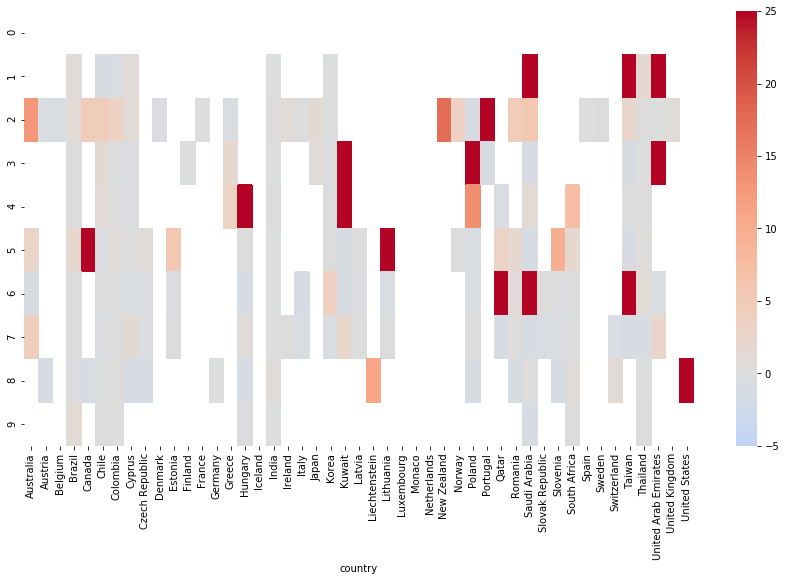

In [57]:
plt.figure(figsize=(15,8))
sns.heatmap(recipient_growth_pct.drop('group', axis=1), cmap='coolwarm', vmin=-5, center=0, vmax=25)

In [58]:
# Recipient growth percentage:

# After initial injection of aid to Czech Republic, Romania, Estonia, Latvia saw a slight drop in the amount of aid in the following years. 
# Reductions in aid disbursements could be driven by the disappearance of an important motive for aid. 
# Lithuania had a 33% increase in average aid in the next 5 years after the initial offering, while Slovenia had a 10% increase. Aid for these 2 countries also remained almost constant in the following years
#  

In [86]:
donor_growth_pct1 = donor_growth_pct.replace(np.inf, 'NA')
donor_growth_pct1 = donor_growth_pct1.replace(np.nan, 'NA')

donor_growth_pctm = pd.melt(donor_growth_pct1, id_vars=['group'])
#donor_growth_pctm.fillna(0, inplace=True)
donor_growth_pctm['index'] = donor_growth_pctm['group'].astype(str) + '-' + donor_growth_pctm['country']
#donor_growth_pctm = donor_growth_pctm[donor_growth_pctm['value'] != 'NA']

recipient_growth_pct1 = recipient_growth_pct.replace(np.inf, 'NA')
recipient_growth_pct1 = recipient_growth_pct1.replace(np.nan, 'NA')

recipient_growth_pctm = pd.melt(recipient_growth_pct1, id_vars=['group'])
#recipient_growth_pctm.fillna(0, inplace=True)
recipient_growth_pctm['index'] = recipient_growth_pctm['group'].astype(str) + '-' + recipient_growth_pctm['country']
#recipient_growth_pctm = recipient_growth_pctm[recipient_growth_pctm['value'] != 'NA']

donor_ratio_m = pd.melt(donor_ratio, id_vars=['group'])
donor_ratio_m['index'] = donor_ratio_m['group'].astype(str) + '-' + donor_ratio_m['country']

In [87]:
# Define the sorter
sorter = list(gdp_m[gdp_m['year'] == 2011].sort_values('value', ascending=False).country)

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(sorter,range(len(sorter))))

# Generate a rank column that will be used to sort the dataframe numerically
donor_ratio_m['country_Rank'] = donor_ratio_m['country'].map(sorterIndex)
donor_ratio_m = donor_ratio_m.sort_values(['group','country_Rank'], ascending=False).drop('country_Rank', axis=1)

# Generate a rank column that will be used to sort the dataframe numerically
donor_growth_pctm['country_Rank'] = donor_growth_pctm['country'].map(sorterIndex)
donor_growth_pctm = donor_growth_pctm.sort_values(['group','country_Rank'], ascending=False).drop('country_Rank', axis=1)

# Generate a rank column that will be used to sort the dataframe numerically
recipient_growth_pctm['country_Rank'] = recipient_growth_pctm['country'].map(sorterIndex)
recipient_growth_pctm = recipient_growth_pctm.sort_values(['group','country_Rank'], ascending=False).drop('country_Rank', axis=1)

In [88]:
total_donations = all_country_PT1[all_country_PT1['category'] == 'net']
total_donations = pd.melt(total_donations, id_vars=['country', 'category']).rename(columns={'variable': 'year'})
total_donations = group_years(total_donations)
total_donations = total_donations.groupby(['country', 'category', 'group']).mean().reset_index()

In [89]:
donor_ratio_m = pd.merge(donor_ratio_m, donor_growth_pctm.rename(columns={'value': 'donor_growth'}), on=['country', 'group', 'index'], how='left')
donor_ratio_m = pd.merge(donor_ratio_m, recipient_growth_pctm.rename(columns={'value': 'recipient_growth'}), on=['country', 'group', 'index'], how='left')
donor_ratio_m = pd.merge(donor_ratio_m, total_donations.rename(columns={'value': 'total'}), on=['country', 'group'], how='left')

In [90]:
donor_ratio_m.replace('Slovak Republic', 'Slovakia', inplace=True)
donor_ratio_m.replace('Czech Republic', 'Czech Rep.', inplace=True)

In [91]:
#recipient_growth_pctm.to_csv('recipient_growth_pctm.csv', index=False)
#donor_growth_pctm.to_csv('donor_growth_pctm.csv', index=False)
donor_ratio_m.to_csv('donor_ratio_m.csv', index=False)

In [65]:
donor_ratio_m[donor_ratio_m['country'] == 'Saudi Arabia']

,group,country,value,index,donor_growth,recipient_growth,category,total
15,2009-2013,Saudi Arabia,-0.600000,2009-2013-Saudi Arabia,NA,-0.980872,net,1.923658e+05
62,2005-2008,Saudi Arabia,-1.000000,2005-2008-Saudi Arabia,NA,0.385322,net,1.005677e+07
109,2001-2004,Saudi Arabia,-1.000000,2001-2004-Saudi Arabia,NA,-0.991544,net,7.259515e+06
156,1997-2000,Saudi Arabia,-1.000000,1997-2000-Saudi Arabia,NA,220.693,net,8.584900e+08
203,1993-1996,Saudi Arabia,-0.750000,1993-1996-Saudi Arabia,NA,-0.9349,net,3.872426e+06
250,1989-1992,Saudi Arabia,-0.500000,1989-1992-Saudi Arabia,NA,1.07845,net,5.948440e+07
297,1985-1988,Saudi Arabia,0.319811,1985-1988-Saudi Arabia,-0.575348,-0.868805,net,8.781422e+07
344,1981-1984,Saudi Arabia,0.093651,1981-1984-Saudi Arabia,-0.383239,5.56012,net,3.575404e+08
391,1977-1980,Saudi Arabia,0.370111,1977-1980-Saudi Arabia,NA,2042.3,net,2.592655e+08
438,1973-1976,Saudi Arabia,-0.250000,1973-1976-Saudi Arabia,NA,NA,net,1.627425e+04


In [66]:
donor_ratio_m[donor_ratio_m['country'] == 'Portugal']

,group,country,value,index,donor_growth,recipient_growth,category,total
14,2009-2013,Portugal,1.000000,2009-2013-Portugal,1.13699,NA,net,6920702.80
61,2005-2008,Portugal,0.989567,2005-2008-Portugal,-0.176407,NA,net,3266788.75
108,2001-2004,Portugal,1.000000,2001-2004-Portugal,1.97704,NA,net,3932191.50
155,1997-2000,Portugal,1.000000,1997-2000-Portugal,14.9554,NA,net,1320839.00
202,1993-1996,Portugal,0.250000,1993-1996-Portugal,NA,NA,net,82783.25
249,1989-1992,Portugal,0.000000,1989-1992-Portugal,NA,NA,net,0.00
296,1985-1988,Portugal,-0.500000,1985-1988-Portugal,NA,-0.833541,net,6100392.00
343,1981-1984,Portugal,-0.500000,1981-1984-Portugal,NA,34.4415,net,36647955.00
390,1977-1980,Portugal,-0.250000,1977-1980-Portugal,NA,NA,net,1034040.00
437,1973-1976,Portugal,0.000000,1973-1976-Portugal,NA,NA,net,0.00


In [67]:
donor_ratio_m.group.unique()

array(['2009-2013', '2005-2008', '2001-2004', '1997-2000', '1993-1996',
       '1989-1992', '1985-1988', '1981-1984', '1977-1980', '1973-1976'],
      dtype=object)

In [94]:
all_country[all_country['category'] == 'recipient'].sort_values('pct', ascending=False)

,category,country,pct,sum,year,group
2111,recipient,India,70.582079,3.000656e+09,1975,1973-1976
3649,recipient,India,65.970283,5.386225e+09,2007,2005-2008
2207,recipient,India,64.876857,3.197135e+09,1977,1977-1980
2255,recipient,India,60.999704,2.927325e+09,1978,1977-1980
2159,recipient,India,60.435512,2.233586e+09,1976,1973-1976
2736,recipient,India,59.776545,3.844238e+09,1988,1985-1988
2640,recipient,India,59.181526,3.003947e+09,1986,1985-1988
2687,recipient,India,57.241311,4.191376e+09,1987,1985-1988
3934,recipient,India,55.458865,4.550646e+09,2013,2009-2013
3838,recipient,India,55.180049,3.652446e+09,2011,2009-2013


In [95]:
all_country_pct

NameError: name 'all_country_pct' is not defined